# Generating Synthetic MMM Data

## Prepare Notebook

In [40]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generating Covariates Data

In [3]:
n_dates = 100

date_range = pd.date_range(start="2020-01-01", freq="W-MON", periods=n_dates)

coords = {"channel": ["x1", "x2", "x3"], "date": date_range}

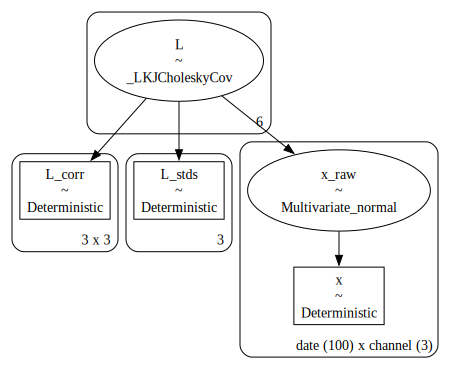

In [4]:
with pm.Model(coords=coords) as covariates_model:
    L, _, _ = pm.LKJCholeskyCov("L", n=3, eta=1, sd_dist=pm.Exponential.dist(lam=1))

    x_raw = pm.MvNormal("x_raw", mu=0, chol=L, dims=("date", "channel"))

    x = pm.Deterministic("x", pt.softplus(x_raw), dims=("date", "channel"))

pm.model_to_graphviz(covariates_model)

In [27]:
x_data = pm.draw(covariates_model.x, draws=1, random_seed=rng)

mmm_df = pd.DataFrame(x_data, columns=coords["channel"]).assign(
    date=date_range, y_dummy=np.ones(n_dates)
)

col = mmm_df.pop("date")
mmm_df.insert(0, "date", col)

mmm_df.head()

,date,x1,x2,x3,y_dummy
0,2020-01-06,0.757087,0.344151,0.519135,1.0
1,2020-01-13,0.822791,1.201837,3.125867,1.0
2,2020-01-20,0.700362,0.398340,0.045832,1.0
3,2020-01-27,0.641115,0.137594,0.000784,1.0
4,2020-02-03,1.030518,0.428180,2.711965,1.0


## Specify Model Configuration

In [59]:
model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2),
    "adstock_alpha": Prior("Beta", alpha=1, beta=3, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=1, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=3, beta=1, dims="channel"),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05, dims="control"),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2, dims="fourier_mode"),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
}

mmm_generator = MMM(
    date_column="date",
    target_column="y_dummy",
    channel_columns=coords["channel"],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    yearly_seasonality=3,
    model_config=model_config,
)

## Generate Target Variable

In [60]:
X = mmm_df.drop(columns=["y_dummy"])
y_dummy = mmm_df["y_dummy"]

mmm_generator.build_model(X, y_dummy)

In [61]:
y_obs = pm.draw(mmm_generator.model.y, draws=1, random_seed=rng)

mmm_df["y_obs"] = y_obs

mmm_df.head()

,date,x1,x2,x3,y_dummy,y_obs
0,2020-01-06,0.757087,0.344151,0.519135,1.0,-2.308627
1,2020-01-13,0.822791,1.201837,3.125867,1.0,8.092522
2,2020-01-20,0.700362,0.398340,0.045832,1.0,3.537431
3,2020-01-27,0.641115,0.137594,0.000784,1.0,1.748554
4,2020-02-03,1.030518,0.428180,2.711965,1.0,1.246247


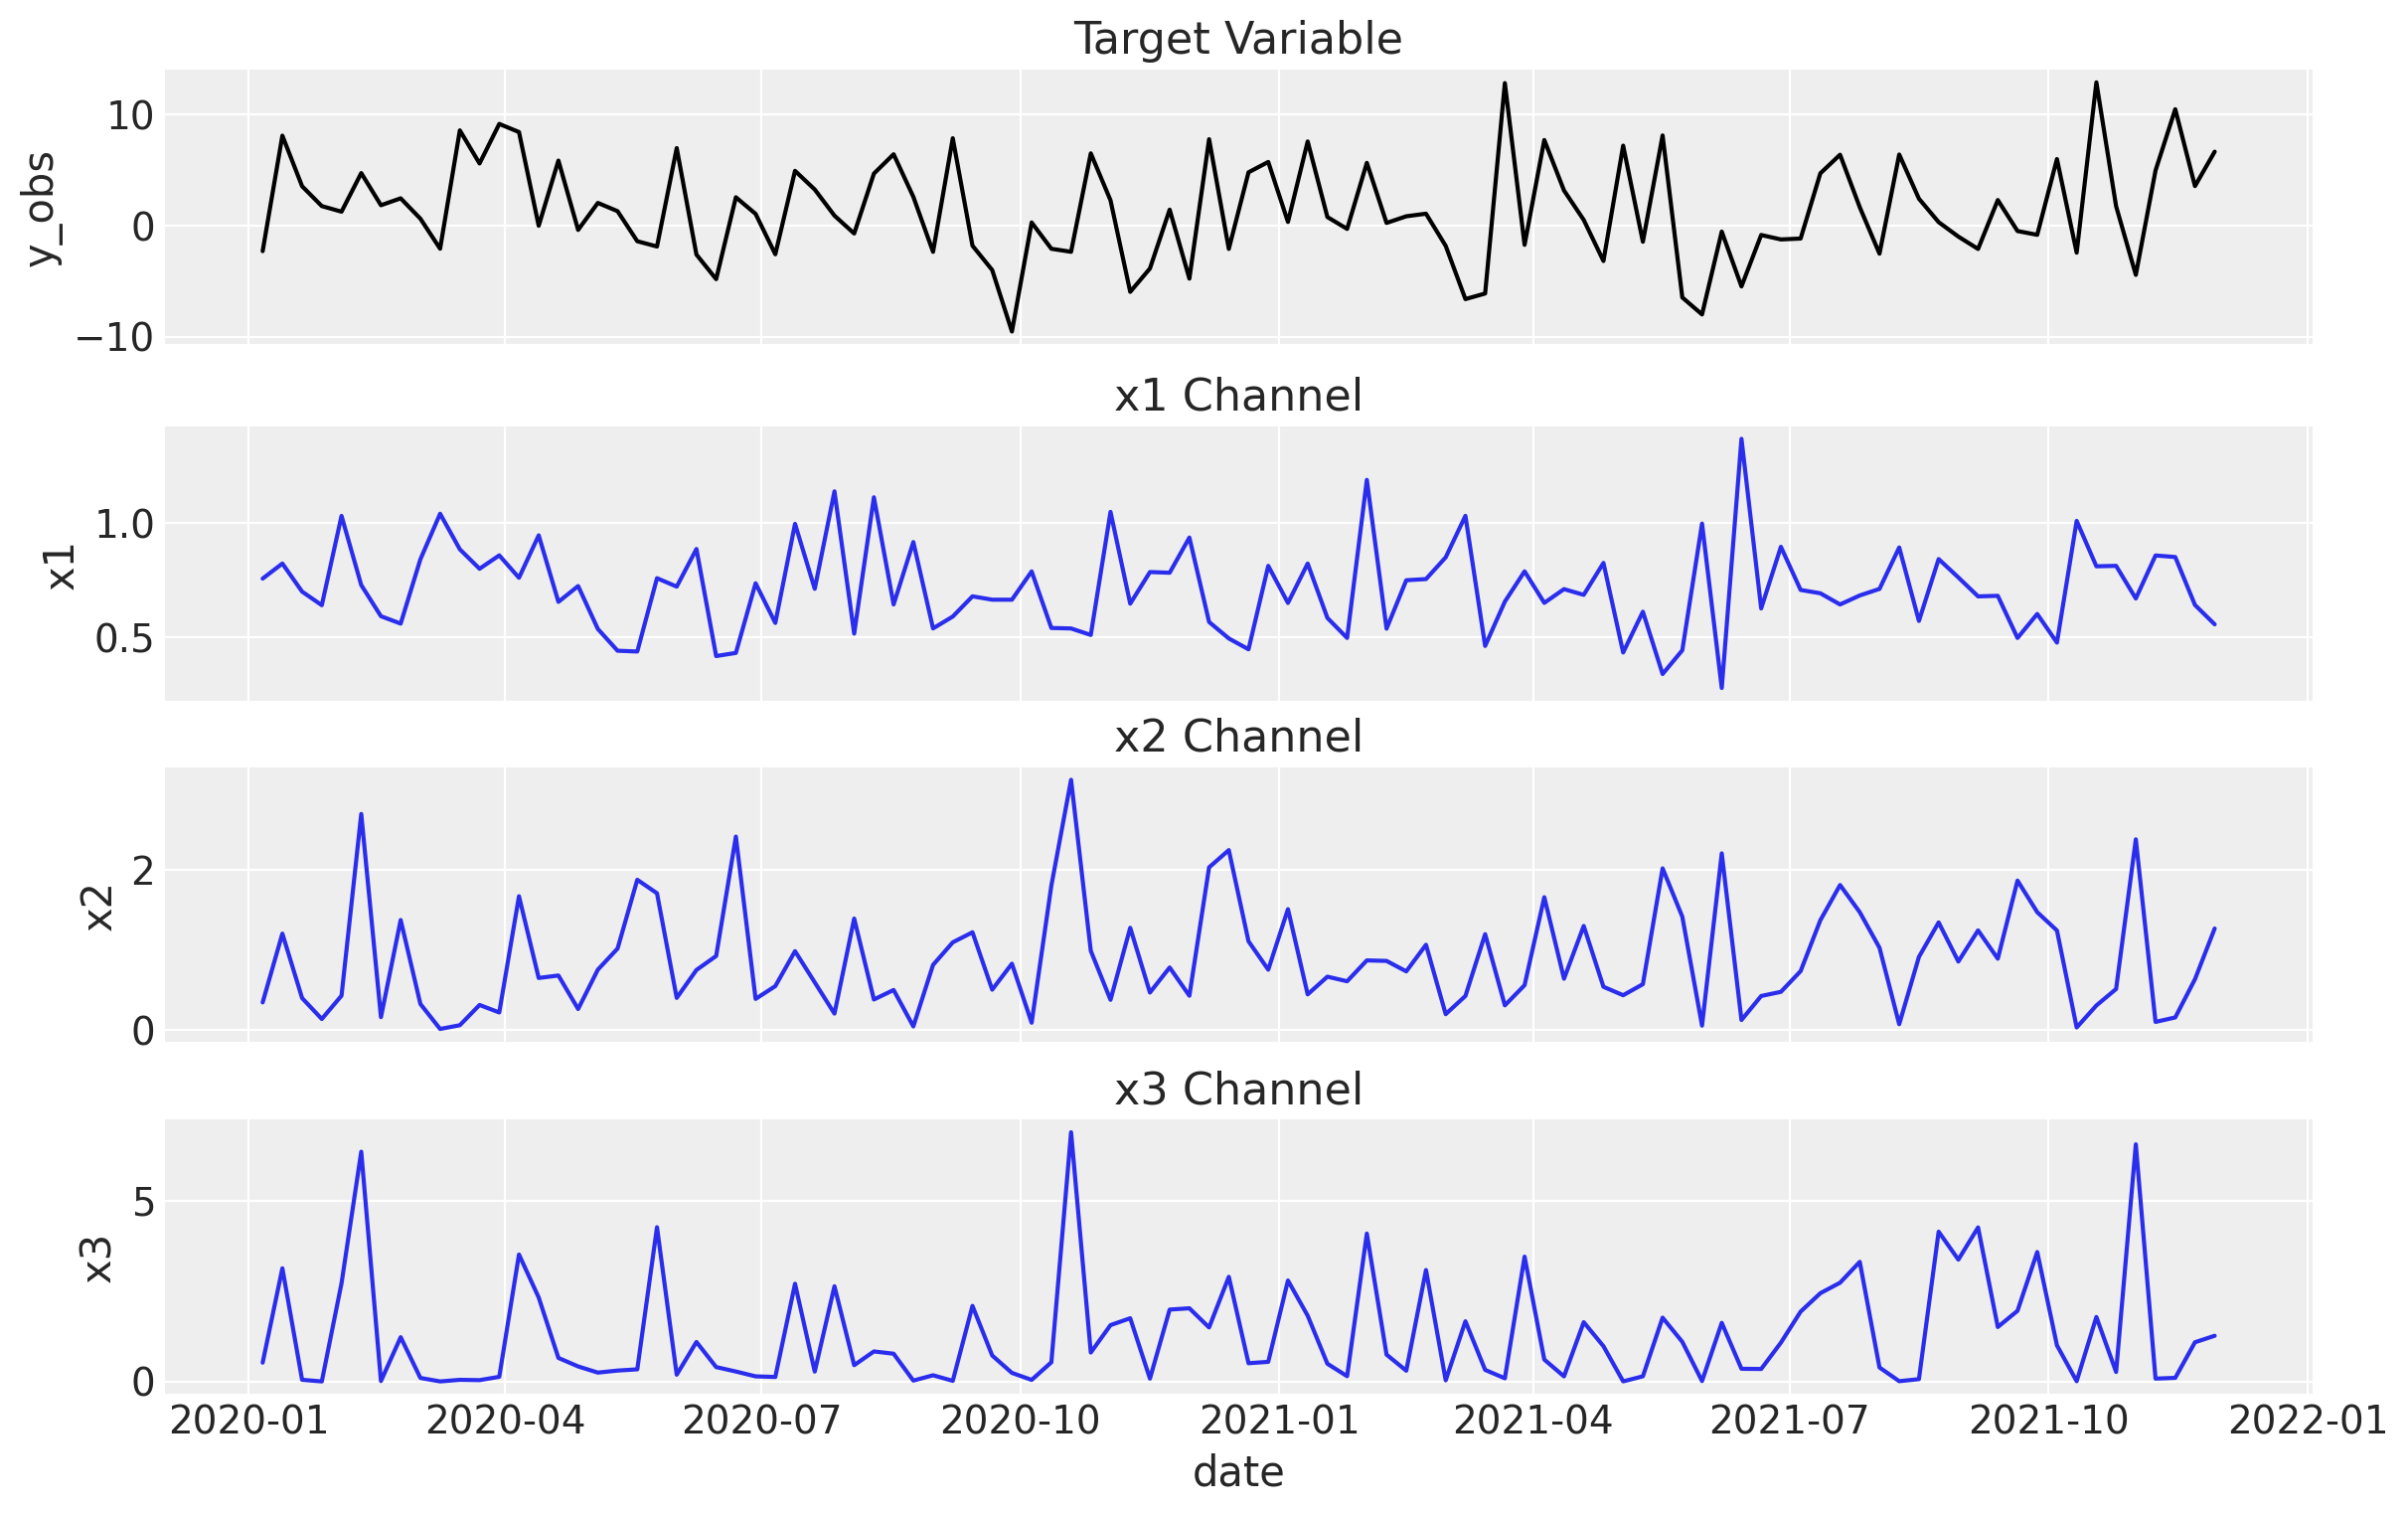

In [62]:
fig, ax = plt.subplots(
    nrows=len(coords["channel"]) + 1,
    figsize=(12, len(coords["channel"]) * 2.5),
    sharex=True,
)

sns.lineplot(x="date", y="y_obs", data=mmm_df, color="black", ax=ax[0])
ax[0].set_title("Target Variable")

for i, channel in enumerate(coords["channel"]):
    sns.lineplot(x="date", y=channel, data=mmm_df, color="C0", ax=ax[i + 1])
    ax[i + 1].set_title(f"{channel} Channel")

## Fit MMM